In [32]:
%pylab inline
from astropy.io import fits
import glob
import pandas as pd
from scipy.interpolate import interp1d
from nirspec import divspec, gluespec
import pdb as pdb

Populating the interactive namespace from numpy and matplotlib


**20101213**

In [2]:
datadir='/Users/hanna/Desktop/URSI/Summer_Research/data/data/'
filelist=glob.glob(datadir+'*20101213*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\ABAUR_20101213_1156_spec1d1.fits 1.15841 M-WIDE-AO 4.711393
data\ABAUR_20101213_1156_spec1d2.fits 1.15841 M-WIDE-AO 5.023287
data\ABAUR_20101213_1224_spec1d1.fits 1.24094 M-WIDE-AO 4.711393
data\ABAUR_20101213_1224_spec1d2.fits 1.24094 M-WIDE-AO 5.023287
data\DRTAU_20101213_0724_spec1d1.fits 1.18798 M-WIDE-AO 4.711393
data\DRTAU_20101213_0724_spec1d2.fits 1.18798 M-WIDE-AO 5.023287
data\DRTAU_20101213_0756_spec1d1.fits 1.10495 M-WIDE-AO 4.711393
data\DRTAU_20101213_0756_spec1d2.fits 1.10495 M-WIDE-AO 5.023287
data\DRTAU_20101213_0827_spec1d1.fits 1.05042 M-WIDE-AO 4.711393
data\DRTAU_20101213_0827_spec1d2.fits 1.05042 M-WIDE-AO 5.023287
data\DRTAU_20101213_0850_spec1d1.fits 1.02386 M-WIDE-AO 4.711393
data\DRTAU_20101213_0850_spec1d2.fits 1.02386 M-WIDE-AO 5.023287
data\GKTAU_20101213_0926_spec1d1.fits 1.00873 M-WIDE-AO 4.713
data\GKTAU_20101213_0926_spec1d2.fits 1.00873 M-WIDE-AO 5.023287
data\GKTAU_20101213_0948_spec1d1.fits 1.00634 M-WIDE-AO 4.711393
data\GKTAU_20101213_0948_spe

SNR: 28.1874094630897 21.22831835003076 7.033186293442487
Writing to:  ABAUR_HR1620_20101213_1156_M1_div.fits


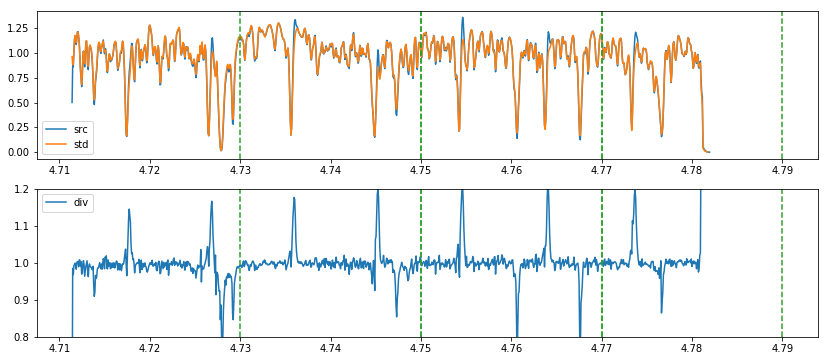

SNR: 57.45455323043106 94.47486099239393 83.67417613596555
Writing to:  ABAUR_HR1620_20101213_1156_M3_div.fits


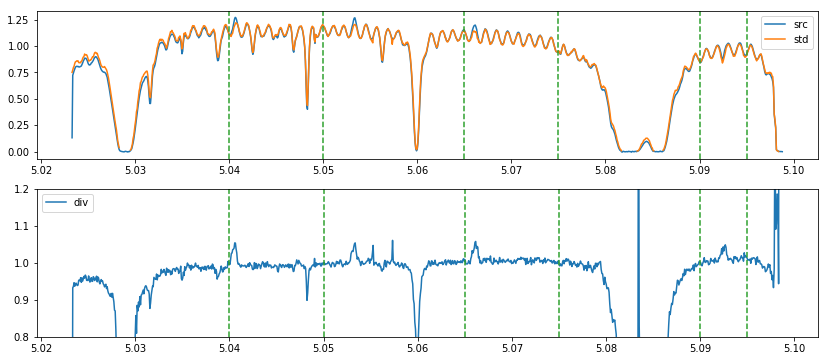

SNR: 24.965665933878267 18.177655251157372 2.4480008127695956
Writing to:  ABAUR_HR1620_20101213_1224_M1_div.fits


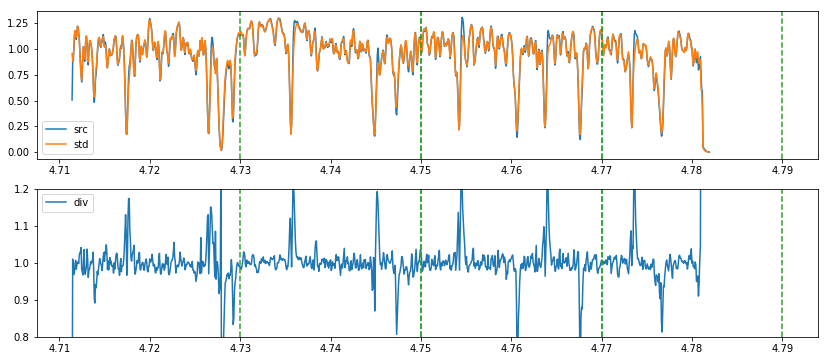

SNR: 51.45138132102897 64.3424139367356 56.792927104579675
Writing to:  ABAUR_HR1620_20101213_1224_M3_div.fits


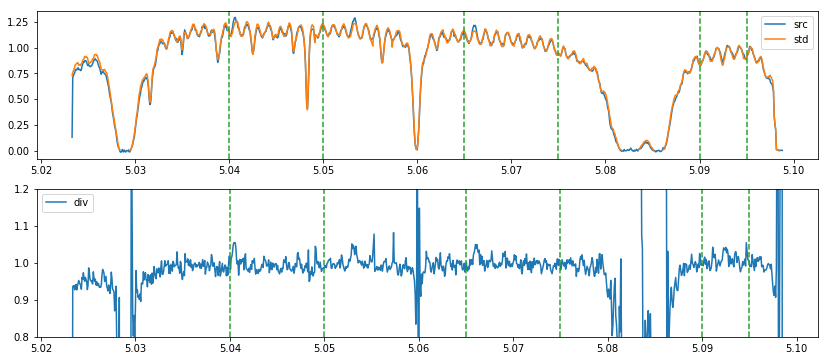

In [112]:
#20101213
srcfile='ABAUR_20101213_1156_spec1d1.fits'
stdfile='HR1620_20101213_0919_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.2, mode='M1')

srcfile='ABAUR_20101213_1156_spec1d2.fits'
stdfile='HR1620_20101213_0919_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.09, dpix=-0.1, mode='M3')

srcfile='ABAUR_20101213_1224_spec1d1.fits'
stdfile='HR1620_20101213_0926_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.05, dpix=-0.3, mode='M1')

srcfile='ABAUR_20101213_1224_spec1d2.fits'
stdfile='HR1620_20101213_0926_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.21, dpix=-0.1, mode='M3')



**20101214**

In [4]:
datadir='/Users/hanna/Desktop/URSI/Summer_Research/data/data/'
filelist=glob.glob(datadir+'*20101214*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\ABAUR_20101214_1032_spec1d1.fits 1.03489 M-WIDE-AO 4.711393
data\ABAUR_20101214_1032_spec1d2.fits 1.03489 M-WIDE-AO 5.023287
data\ABAUR_20101214_1057_spec1d1.fits 1.05918 M-WIDE-AO 4.711393
data\ABAUR_20101214_1057_spec1d2.fits 1.05918 M-WIDE-AO 5.023287
data\HD50138_20101214_1331_spec1d1.fits 1.26791 M-WIDE-AO 4.711393
data\HD50138_20101214_1331_spec1d2.fits 1.26791 M-WIDE-AO 5.023287
data\HD50138_20101214_1350_spec1d1.fits 1.33451 M-WIDE-AO 4.711393
data\HD50138_20101214_1350_spec1d2.fits 1.33451 M-WIDE-AO 5.023287
data\HR1620_20101214_0900_spec1d1.fits 1.02489 M-WIDE-AO 4.711393
data\HR1620_20101214_0900_spec1d2.fits 1.02489 M-WIDE-AO 5.023287
data\HR1620_20101214_1236_spec1d1.fits 1.2675 M-WIDE-AO 4.711393
data\HR1620_20101214_1236_spec1d2.fits 1.2675 M-WIDE-AO 5.023287
data\HR383_20101214_0459_spec1d1.fits 1.05036 M-WIDE-AO 4.711393
data\HR383_20101214_0459_spec1d2.fits 1.05036 M-WIDE-AO 5.023287
data\HR4494_20101214_1607_spec1d1.fits 1.73261 M-WIDE-AO 4.711393
data\HR4494_20

SNR: 23.524471987031614 15.202713466080441 21.55418245236198
Writing to:  ABAUR_HR1620_20101214_1032_M1_div.fits


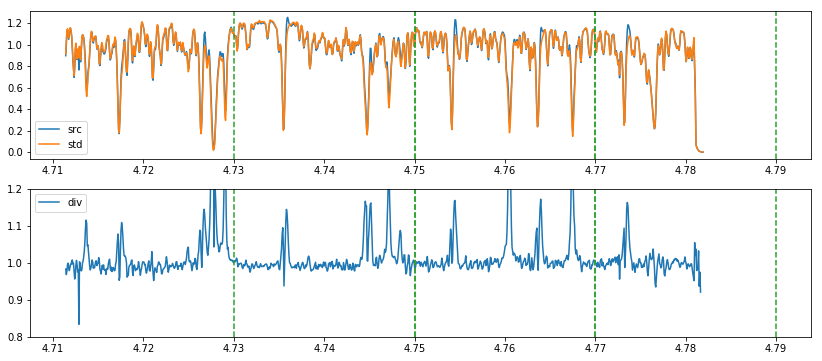

SNR: 33.11889192203591 93.03829777438298 77.1357606899407
Writing to:  ABAUR_HR1620_20101214_1032_M3_div.fits


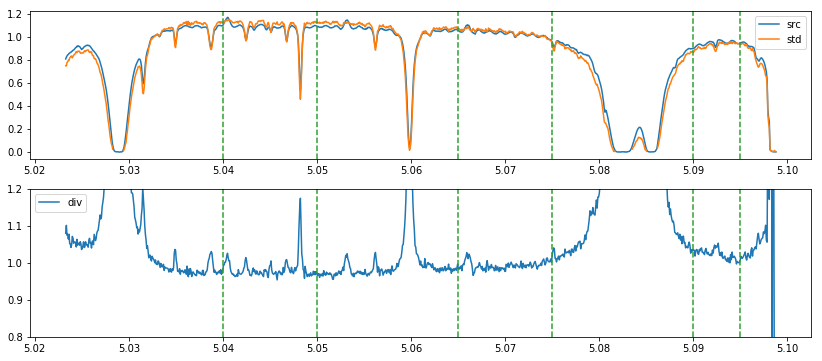

SNR: 32.49033568001675 30.73606780610209 4.735150144690452
Writing to:  ABAUR_HR383_20101214_1057_M1_div.fits


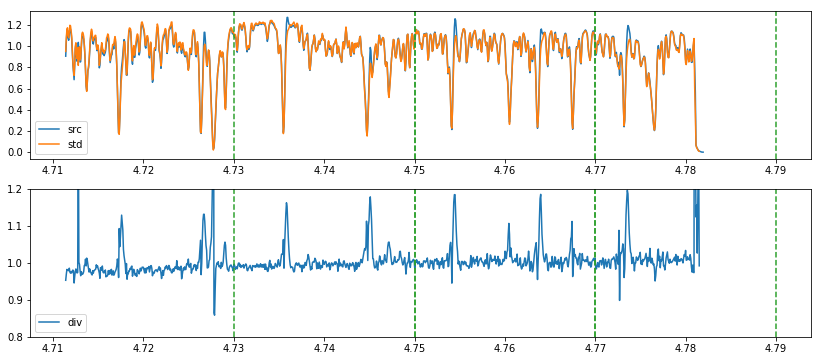

SNR: 64.81165567854448 61.151175672652315 66.11624483234696
Writing to:  ABAUR_HR383_20101214_1057_M3_div.fits


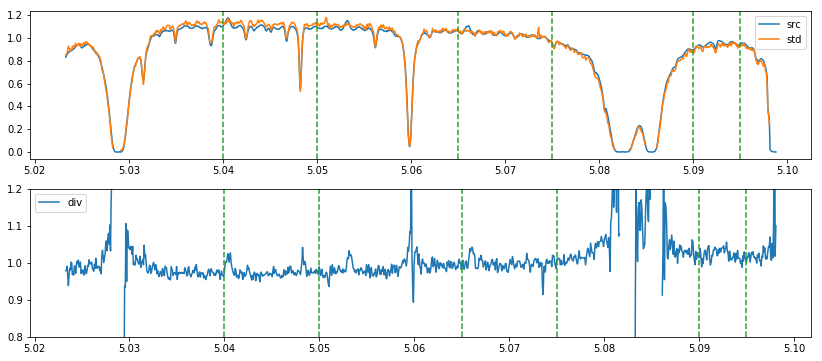

In [27]:
#20101214
srcfile='ABAUR_20101214_1032_spec1d1.fits'
stdfile='HR1620_20101214_0900_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.0, dpix=-0.1, mode='M1')

srcfile='ABAUR_20101214_1032_spec1d2.fits'
stdfile='HR1620_20101214_0900_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.00, dpix=-0.1, mode='M3')

srcfile='ABAUR_20101214_1057_spec1d1.fits'
stdfile='HR383_20101214_0459_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.01, dpix=-0.5, mode='M1')

srcfile='ABAUR_20101214_1057_spec1d2.fits'
stdfile='HR383_20101214_0459_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.01, dpix=-0.3, mode='M3')



**20121231**

In [6]:
datadir='/Users/hanna/Desktop/URSI/Summer_Research/data/data/'
filelist=glob.glob(datadir+'*20121231*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\AATAU_20121231_0605_spec1d1.fits 1.16434 M-WIDE-AO 4.646994
data\AATAU_20121231_0605_spec1d2.fits 1.16434 M-WIDE-AO 4.954114
data\AATAU_20121231_0638_spec1d1.fits 1.08767 M-WIDE-AO 4.646994
data\AATAU_20121231_0638_spec1d2.fits 1.08767 M-WIDE-AO 4.954114
data\ABAUR_20121231_1051_spec1d1.fits 1.17909 M-WIDE-AO 4.711393
data\ABAUR_20121231_1051_spec1d2.fits 1.17909 M-WIDE-AO 5.023287
data\ABAUR_20121231_1120_spec1d1.fits 1.27035 M-WIDE-AO 4.711393
data\ABAUR_20121231_1120_spec1d2.fits 1.27035 M-WIDE-AO 5.023287
data\FNTAU_20121231_0731_spec1d1.fits 1.0164 M-WIDE-AO 4.711393
data\FNTAU_20121231_0731_spec1d2.fits 1.0164 M-WIDE-AO 5.023287
data\FNTAU_20121231_0810_spec1d1.fits 1.01305 M-WIDE-AO 4.711393
data\FNTAU_20121231_0810_spec1d2.fits 1.01305 M-WIDE-AO 5.023287
data\HR1177_20121231_0848_spec1d1.fits 1.07626 M-WIDE-AO 4.711393
data\HR1177_20121231_0848_spec1d2.fits 1.07626 M-WIDE-AO 5.023287
data\HR1620_20121231_0550_spec1d1.fits 1.31901 M-WIDE-AO 4.646994
data\HR1620_20121231_055

SNR: 19.333518015263387 20.858211916229077 13.67466304896851
Writing to:  ABAUR_HR2714_20121231_1051_M1_div.fits


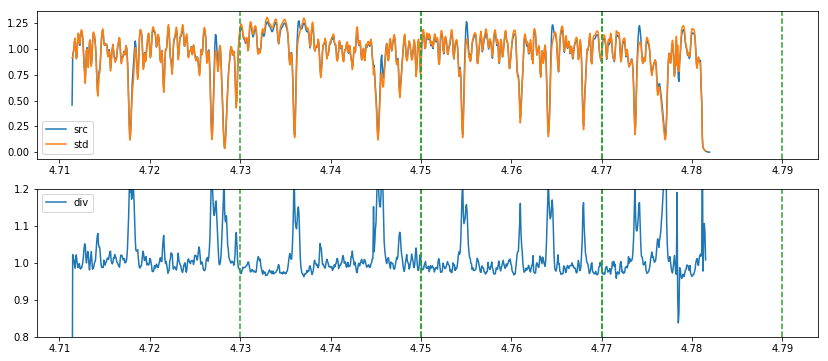

SNR: 63.09545869396841 119.51614397941377 87.22982545225463
Writing to:  ABAUR_HR2714_20121231_1051_M3_div.fits


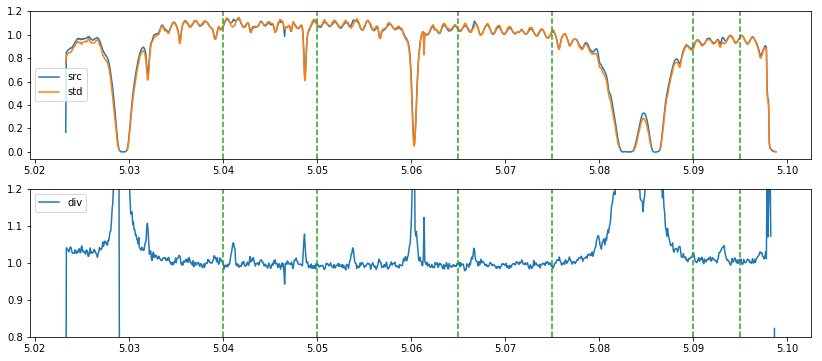

SNR: 12.95857752110088 15.124764577587172 6.852361994555833
Writing to:  ABAUR_HR4494_20121231_1120_M1_div.fits


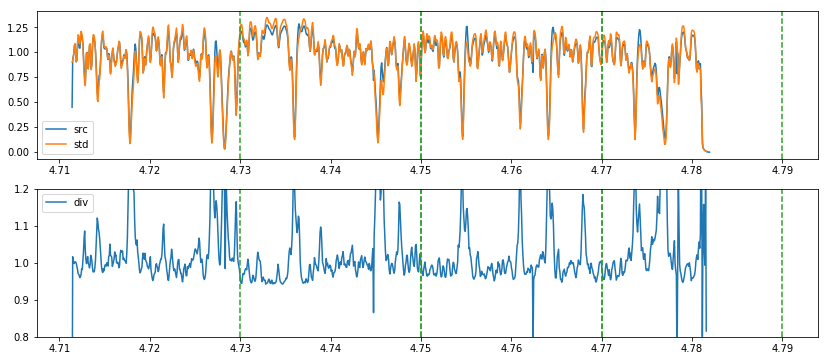

SNR: 48.23463667215806 93.10708680314926 74.7169194863943
Writing to:  ABAUR_HR4494_20121231_1120_M3_div.fits


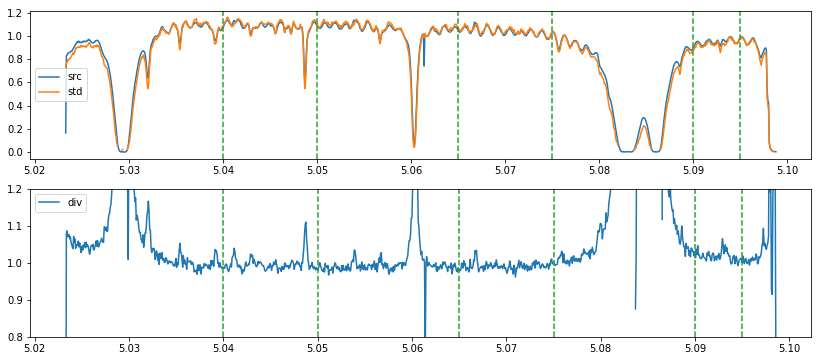

In [7]:
#20121231
srcfile='ABAUR_20121231_1051_spec1d1.fits'
stdfile='HR2714_20121231_1330_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.0, dpix=-0.0, mode='M1')

srcfile='ABAUR_20121231_1051_spec1d2.fits'
stdfile='HR2714_20121231_1330_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.0, dpix=-0.1, mode='M3')

srcfile='ABAUR_20121231_1120_spec1d1.fits'
stdfile='HR4494_20121231_1456_spec1d1.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.00, dpix=-0.2, mode='M1')

srcfile='ABAUR_20121231_1120_spec1d2.fits'
stdfile='HR4494_20121231_1456_spec1d2.fits'
out=divspec(datadir, srcfile, stdfile, dtau=0.01, dpix=-0.1, mode='M3')



**20130101**

In [8]:
datadir='/Users/hanna/Desktop/URSI/Summer_Research/data/data/'
filelist=glob.glob(datadir+'*20130101*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\AATAU_20130101_0555_spec1d1.fits 1.18091 M-WIDE-AO 4.711393
data\AATAU_20130101_0555_spec1d2.fits 1.18091 M-WIDE-AO 5.023287
data\AATAU_20130101_0618_spec1d1.fits 1.11999 M-WIDE-AO 4.711393
data\AATAU_20130101_0618_spec1d2.fits 1.11999 M-WIDE-AO 5.023287
data\ABAUR_20130101_1056_spec1d1.fits 1.20446 M-WIDE-AO 4.646994
data\ABAUR_20130101_1056_spec1d2.fits 1.20446 M-WIDE-AO 4.954114
data\ABAUR_20130101_1122_spec1d1.fits 1.29239 M-WIDE-AO 4.646994
data\ABAUR_20130101_1122_spec1d2.fits 1.29239 M-WIDE-AO 4.954114
data\GMAUR_20130101_0705_spec1d1.fits 1.08204 M-WIDE-AO 4.711393
data\GMAUR_20130101_0705_spec1d2.fits 1.08204 M-WIDE-AO 5.023287
data\GMAUR_20130101_0758_spec1d1.fits 1.02657 M-WIDE-AO 4.711393
data\GMAUR_20130101_0758_spec1d2.fits 1.02657 M-WIDE-AO 5.023287
data\HR1177_20130101_0843_spec1d1.fits 1.07433 M-WIDE-AO 4.711393
data\HR1177_20130101_0843_spec1d2.fits 1.07433 M-WIDE-AO 5.023287
data\HR1620_20130101_0540_spec1d1.fits 1.34607 M-WIDE-AO 4.711393
data\HR1620_20130101_0

There is something weird about the 20130101 data onward.

In [9]:
#20130101
srcfile='ABAUR_20130101_1056_spec1d1.fits'
stdfile='HR1620_20130101_1028_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.09, dpix=0.2, mode='M0')

srcfile='ABAUR_20130101_1056_spec1d2.fits'
stdfile='HR1620_20130101_1028_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=0.2, mode='M2')

srcfile='ABAUR_20130101_1122_spec1d1.fits'
stdfile='HR2714_20130101_1322_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.01, dpix=0.1, mode='M0')

srcfile='ABAUR_20130101_1122_spec1d2.fits'
stdfile='HR2714_20130101_1322_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.08, dpix=-0.2, mode='M2')



**20130103**

In [10]:
datadir='/Users/hanna/Desktop/URSI/Summer_Research/data/data/'
filelist=glob.glob(datadir+'*20130103*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\ABAUR_20130103_0837_spec1d1.fits 1.0187 M-WIDE-AO 4.646994
data\ABAUR_20130103_0837_spec1d2.fits 1.0187 M-WIDE-AO 4.954114
data\ABAUR_20130103_0913_spec1d1.fits 1.03557 M-WIDE-AO 4.646994
data\ABAUR_20130103_0913_spec1d2.fits 1.03557 M-WIDE-AO 4.954114
data\HD50138_20130103_1005_spec1d1.fits 1.12255 M-WIDE-AO 4.646994
data\HD50138_20130103_1005_spec1d2.fits 1.12255 M-WIDE-AO 4.954114
data\HD50138_20130103_1238_spec1d1.fits 1.3686 M-WIDE-AO 4.646994
data\HD50138_20130103_1238_spec1d2.fits 1.3686 M-WIDE-AO 4.954114
data\HR1620_20130103_0644_spec1d1.fits 1.1078 M-WIDE-AO 4.646994
data\HR1620_20130103_0644_spec1d2.fits 1.1078 M-WIDE-AO 4.954114
data\HR1620_20130103_0718_spec1d1.fits 1.04866 M-WIDE-AO 4.646994
data\HR1620_20130103_0718_spec1d2.fits 1.04866 M-WIDE-AO 4.954114
data\HR1620_20130103_0823_spec1d1.fits 1.00125 M-WIDE-AO 4.646994
data\HR1620_20130103_0823_spec1d2.fits 1.00125 M-WIDE-AO 4.954114
data\HR1620_20130103_1314_spec1d1.fits 1.35828 M-WIDE-AO 4.646994
data\HR1620_2013

In [11]:
#20130101
srcfile='ABAUR_20130103_0837_spec1d1.fits'
stdfile='HR1620_20130103_0823_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.0, dpix=0.6, mode='M0')

srcfile='ABAUR_20130103_0837_spec1d2.fits'
stdfile='HR1620_20130103_0823_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.01, dpix=-0.9, mode='M2')

srcfile='ABAUR_20130103_0913_spec1d1.fits'
stdfile='HR1620_20130103_0718_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.02, dpix=-0.2, mode='M0')

srcfile='ABAUR_20130103_0913_spec1d2.fits'
stdfile='HR1620_20130103_0718_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.02, dpix=-0.3, mode='M2')



**20131223**

In [12]:
datadir='/Users/hanna/Desktop/URSI/Summer_Research/data/data/'
filelist=glob.glob(datadir+'*20131223*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\AATAU_20131223_0734_spec1d1.fits 1.05152 M-WIDE-AO 4.646994
data\AATAU_20131223_0734_spec1d2.fits 1.05152 M-WIDE-AO 4.954114
data\AATAU_20131223_0758_spec1d1.fits 1.02458 M-WIDE-AO 4.646994
data\AATAU_20131223_0758_spec1d2.fits 1.02458 M-WIDE-AO 4.954114
data\ABAUR_20131223_1118_spec1d1.fits 1.16299 M-WIDE-AO 4.646994
data\ABAUR_20131223_1118_spec1d2.fits 1.16299 M-WIDE-AO 4.954114
data\ABAUR_20131223_1136_spec1d1.fits 1.21435 M-WIDE-AO 4.646994
data\ABAUR_20131223_1136_spec1d2.fits 1.21435 M-WIDE-AO 4.954114
data\DOTAU_20131223_0559_spec1d1.fits 1.31167 M-WIDE-AO 4.646994
data\DOTAU_20131223_0559_spec1d2.fits 1.31167 M-WIDE-AO 4.954114
data\DOTAU_20131223_0653_spec1d1.fits 1.13377 M-WIDE-AO 4.646994
data\DOTAU_20131223_0653_spec1d2.fits 1.13377 M-WIDE-AO 4.954114
data\DOTAU_20131223_0700_spec1d1.fits 1.11806 M-WIDE-AO 4.646994
data\DOTAU_20131223_0700_spec1d2.fits 1.11806 M-WIDE-AO 4.954114
data\FNTAU_20131223_0827_spec1d1.fits 1.01141 M-WIDE-AO 4.646994
data\FNTAU_20131223_0827_

In [13]:
#20131223
srcfile='ABAUR_20131223_1118_spec1d1.fits'
stdfile='HR1177_20131223_0543_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.0, dpix=-0.1, mode='M0')

srcfile='ABAUR_20131223_1118_spec1d2.fits'
stdfile='HR1177_20131223_0543_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.01, dpix=-0.3, mode='M2')

srcfile='ABAUR_20131223_1136_spec1d1.fits'
stdfile='HR1177_20131223_0543_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.01, dpix=-0.7, mode='M0')

srcfile='ABAUR_20131223_1136_spec1d2.fits'
stdfile='HR1177_20131223_0543_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.01, dpix=-0.4, mode='M2')



**20131224**

In [14]:
datadir='/Users/hanna/Desktop/URSI/Summer_Research/data/data/'
filelist=glob.glob(datadir+'*20131224*.fits')
for i,file in enumerate(filelist):
    filename=(file.split('/'))[-1]
    hdulist=fits.open(file)
    print(filename,hdulist[0].header['AIRMASS'],hdulist[0].header['FILNAME'],hdulist[0].header['WAVA_POS'])

data\ABAUR_20131224_1124_spec1d1.fits 1.19037 M-WIDE-AO 4.646994
data\ABAUR_20131224_1124_spec1d2.fits 1.19037 M-WIDE-AO 4.954114
data\ABAUR_20131224_1143_spec1d1.fits 1.25083 M-WIDE-AO 4.646994
data\ABAUR_20131224_1143_spec1d2.fits 1.25083 M-WIDE-AO 4.954114
data\DOTAU_20131224_0548_spec1d1.fits 1.3405 M-WIDE-AO 4.646994
data\DOTAU_20131224_0548_spec1d2.fits 1.3405 M-WIDE-AO 4.954114
data\DOTAU_20131224_0614_spec1d1.fits 1.23693 M-WIDE-AO 4.646994
data\DOTAU_20131224_0614_spec1d2.fits 1.23693 M-WIDE-AO 4.954114
data\FNTAU_20131224_0728_spec1d1.fits 1.03791 M-WIDE-AO 4.646994
data\FNTAU_20131224_0728_spec1d2.fits 1.03791 M-WIDE-AO 4.954114
data\FNTAU_20131224_0806_spec1d1.fits 1.01414 M-WIDE-AO 4.646994
data\FNTAU_20131224_0806_spec1d2.fits 1.01414 M-WIDE-AO 4.954114
data\GMAUR_20131224_0903_spec1d1.fits 1.01706 M-WIDE-AO 4.646994
data\GMAUR_20131224_0903_spec1d2.fits 1.01706 M-WIDE-AO 4.954114
data\GMAUR_20131224_0944_spec1d1.fits 1.02901 M-WIDE-AO 4.646994
data\GMAUR_20131224_0944_sp

In [15]:
#20131224
srcfile='ABAUR_20131224_1124_spec1d1.fits'
stdfile='HR1177_20131224_0533_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.09, dpix=0.2, mode='M0')

srcfile='ABAUR_20131224_1124_spec1d2.fits'
stdfile='HR1177_20131224_0533_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.00, dpix=-0.1, mode='M2')

srcfile='ABAUR_20131224_1143_spec1d1.fits'
stdfile='HR1620_20131224_0638_spec1d1.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.09, dpix=-0.9, mode='M0')

srcfile='ABAUR_20131224_1143_spec1d2.fits'
stdfile='HR1620_20131224_0638_spec1d2.fits'
#out=divspec(datadir, srcfile, stdfile, dtau=0.05, dpix=-0.5, mode='M2')



**Combining Spectra Together**

In [16]:
ABAUR_20101213_files = ['ABAUR_HR1620_20101213_1156_M1_div.fits', 'ABAUR_HR1620_20101213_1156_M3_div.fits','ABAUR_HR1620_20101213_1224_M1_div.fits', 'ABAUR_HR1620_20101213_1224_M3_div.fits']
ABAUR_20101214_files = ['ABAUR_HR1620_20101214_1032_M1_div.fits', 'ABAUR_HR1620_20101214_1032_M3_div.fits', 'ABAUR_HR383_20101214_1057_M1_div.fits', 'ABAUR_HR383_20101214_1057_M3_div.fits']
ABAUR_20121231_files = ['ABAUR_HR2714_20121231_1051_M1_div.fits', 'ABAUR_HR2714_20121231_1051_M3_div.fits', 'ABAUR_HR4494_20121231_1120_M1_div.fits', 'ABAUR_HR4494_20121231_1120_M3_div.fits']
ABAUR_20130101_files = ['ABAUR_HR1620_20130101_1056_M0_div.fits', 'ABAUR_HR1620_20130101_1056_M2_div.fits', 'ABAUR_HR2714_20130101_1122_M0_div.fits','ABAUR_HR2714_20130101_1122_M2_div.fits']
ABAUR_20130103_files = ['ABAUR_HR1620_20130103_0837_M0_div.fits','ABAUR_HR1620_20130103_0837_M2_div.fits','ABAUR_HR1620_20130103_0913_M0_div.fits','ABAUR_HR1620_20130103_0913_M2_div.fits']
ABAUR_20131223_files = ['ABAUR_HR1177_20131223_1118_M0_div.fits','ABAUR_HR1177_20131223_1118_M2_div.fits','ABAUR_HR1177_20131223_1136_M0_div.fits','ABAUR_HR1177_20131223_1136_M2_div.fits']
ABAUR_20131224_files = ['ABAUR_HR1177_20131224_1124_M0_div.fits','ABAUR_HR1177_20131224_1124_M2_div.fits','ABAUR_HR1620_20131224_1143_M0_div.fits','ABAUR_HR1620_20131224_1143_M2_div.fits']

In [17]:
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/Summer_Research/',ABAUR_20101213_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/Summer_Research/',ABAUR_20101214_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/Summer_Research/',ABAUR_20121231_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/Summer_Research/',ABAUR_20130101_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/Summer_Research/',ABAUR_20130103_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/Summer_Research/',ABAUR_20131223_files)
(wave,div)=gluespec('/Users/hanna/Desktop/URSI/Summer_Research/',ABAUR_20131224_files)

Writing to:  ABAUR_20101213_glue.fits
Writing to:  ABAUR_20101214_glue.fits
Writing to:  ABAUR_20121231_glue.fits
Writing to:  ABAUR_20130101_glue.fits
Writing to:  ABAUR_20130103_glue.fits
Writing to:  ABAUR_20131223_glue.fits
Writing to:  ABAUR_20131224_glue.fits


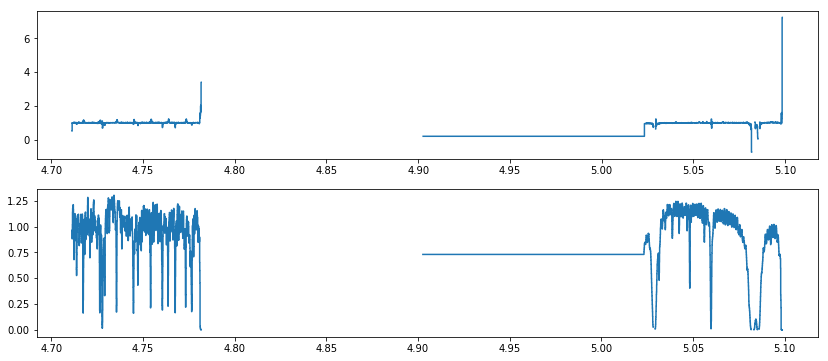

In [18]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20101213_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

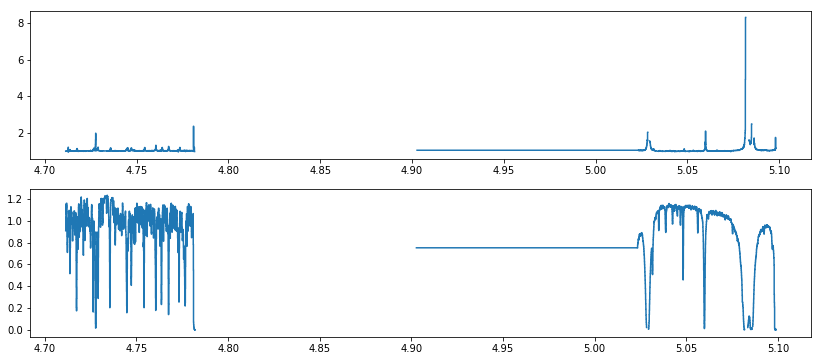

In [19]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20101214_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

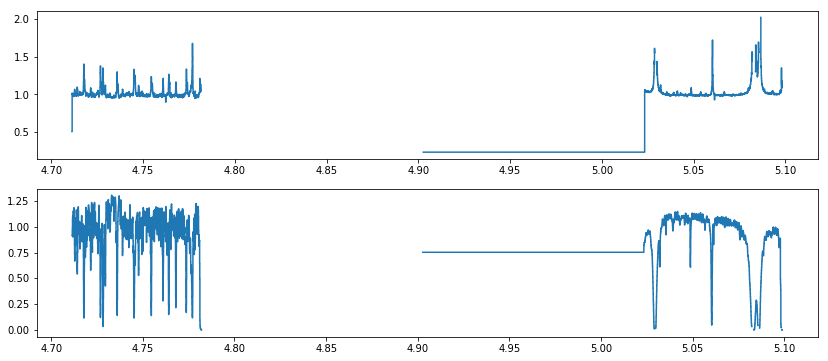

In [20]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20121231_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

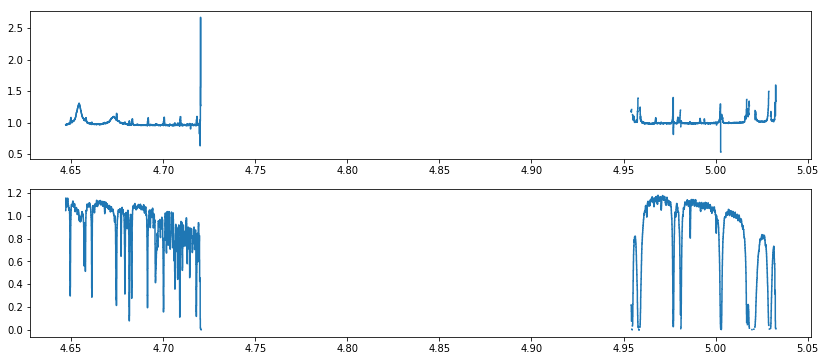

In [21]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20130101_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

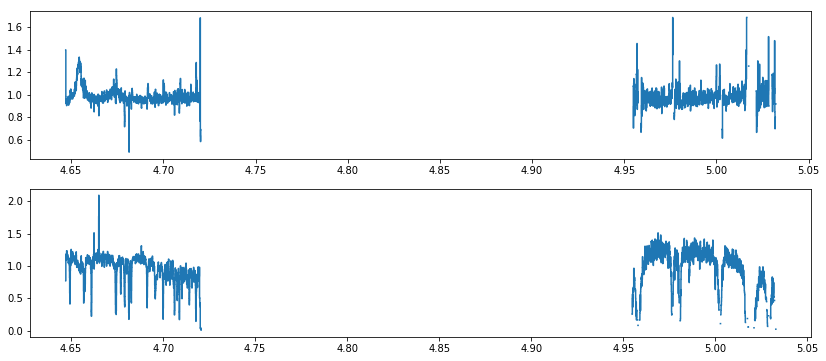

In [22]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20130103_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

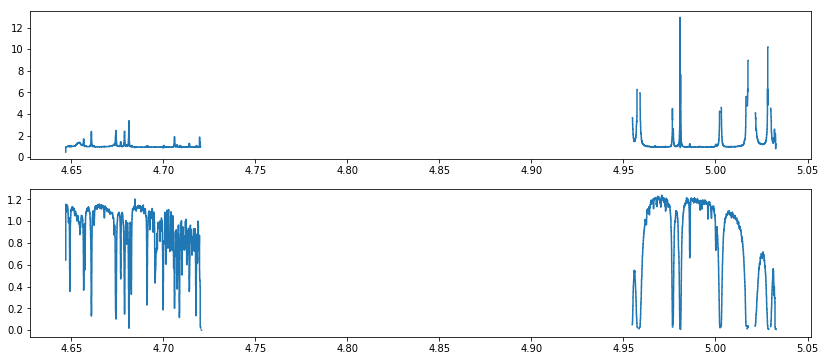

In [23]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20131223_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

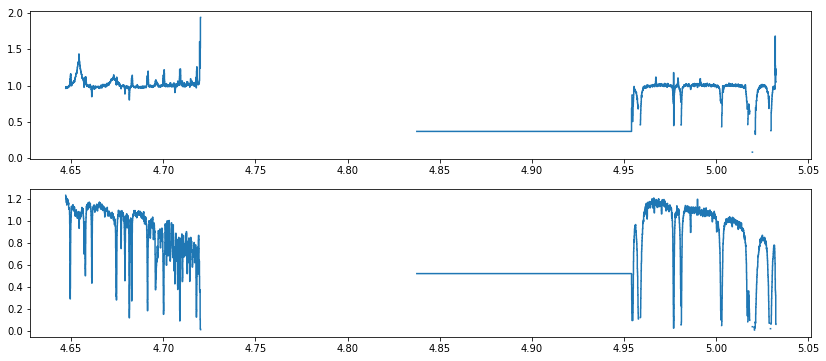

In [53]:
hdulist=fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20131224_glue.fits')
data=hdulist[1].data
fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(data['wave'],data['div'],linestyle='steps-mid')
ax2.plot(data['wave'],data['std'],linestyle='steps-mid')

(0.5, 8)

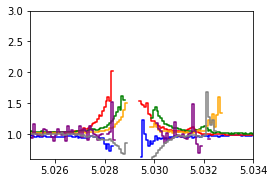

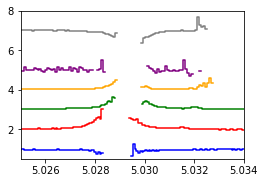

In [167]:
hdulist20101213 = fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20101213_glue.fits')
data20101213 = hdulist20101213[1].data
hdulist20101214 = fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20101214_glue.fits')
data20101214 = hdulist20101214[1].data
hdulist20121231 = fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20121231_glue.fits')
data20121231 = hdulist20121231[1].data
hdulist20130101 = fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20130101_glue.fits')
data20130101 = hdulist20130101[1].data
hdulist20130103 = fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20130103_glue.fits')
data20130103 = hdulist20130103[1].data
hdulist20131223 = fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20131223_glue.fits')
data20131223 = hdulist20131223[1].data
hdulist20131224 = fits.open('/Users/hanna/Desktop/URSI/Summer_Research/ABAUR_20131224_glue.fits')
data20131224 = hdulist20131224[1].data

fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)
ax5 = fig.add_subplot(211)
ax6 = fig.add_subplot(211)
ax7 = fig.add_subplot(211)

plt.plot()
ax1.plot(data20101213['wave'],data20101213['div'],linestyle='steps-mid', color = 'blue')
ax2.plot(data20101214['wave'],data20101214['div'],linestyle='steps-mid', color = 'red')
ax3.plot(data20121231['wave'],data20121231['div'],linestyle='steps-mid', color = 'green')
ax4.plot(data20130101['wave'],data20130101['div'],linestyle='steps-mid', color = 'orange')
ax5.plot(data20130103['wave'],data20130103['div'],linestyle='steps-mid', color = 'purple')
#ax6.plot(data20131223['wave'],data20131223['div'],linestyle='steps-mid', color = 'black')
ax7.plot(data20131224['wave'],data20131224['div'],linestyle='steps-mid', color = 'grey')

plt.xlim([5.025,5.034])
plt.ylim([0.6,3])

fig =plt.figure(figsize(4,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(211)
ax3 = fig.add_subplot(211)
ax4 = fig.add_subplot(211)
ax5 = fig.add_subplot(211)
ax6 = fig.add_subplot(211)
ax7 = fig.add_subplot(211)
ax1.plot(data20101213['wave'],data20101213['div']+0,linestyle='steps-mid', color = 'blue')
ax2.plot(data20101214['wave'],data20101214['div']+1,linestyle='steps-mid', color = 'red')
ax3.plot(data20121231['wave'],data20121231['div']+2,linestyle='steps-mid', color = 'green')
ax4.plot(data20130101['wave'],data20130101['div']+3,linestyle='steps-mid', color = 'orange')
ax5.plot(data20130103['wave'],data20130103['div']+4,linestyle='steps-mid', color = 'purple')
#ax6.plot(data20131223['wave'],data20131223['div']+5,linestyle='steps-mid', color = 'black')
ax7.plot(data20131224['wave'],data20131224['div']+6,linestyle='steps-mid', color = 'grey')

plt.xlim([5.025,5.034])
plt.ylim([0.5,8])